In [1]:
#грузим библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import pymorphy2
import re

from tqdm import notebook

!pip install tabulate
from tabulate import tabulate

In [2]:
import os

pth1 = '/datasets/toxic_comments.csv'
pth2 = 'C:downloads/brewise.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
pd.options.display.max_colwidth = 1000 # чтобы лучше текст прочитать

In [4]:
# посмотрим на количество диалогов df
df.dlg_id.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [5]:
# посмотрим количество текстовых сообщений клиента и менеджера
df.groupby(['role'])['text'].count()

role
client     279
manager    201
Name: text, dtype: int64

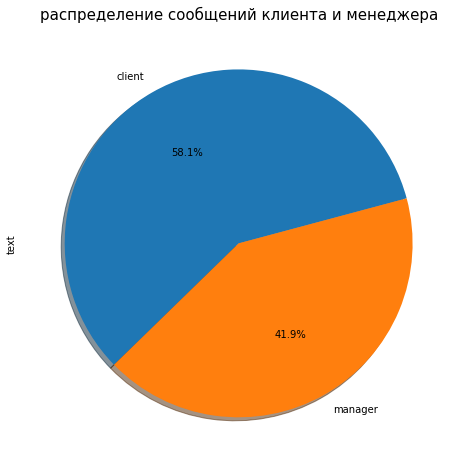

In [6]:
fig,(ax1) = plt.subplots(1, figsize=(15,8))

df.groupby(['role'])['text'].count().plot(kind='pie',ax=ax1,shadow=True,subplots=True, startangle=15,autopct='%0.1f%%')
ax1.set_title('распределение сообщений клиента и менеджера',fontsize=15)

plt.show()

**Вывод:**

* Мы посмотрели первичные данные перед парсингом диалогов.
* Увидели, что клиенты пишут/задают вопросы больше чем менеджеры.
* В наших данных 6 диалогов между клиентами и менеджерами.
* Приступим к выполнению заданию.

---------------------------------------------------




In [7]:
say_hello = []
for i in range(6):
    if re.findall(r'(?i)(\W|^)(здравствуйте|добрый вечер|добрый день|привет|доброе утро|приветствую|доброго времени суток)(\W|$)',
                  str(df.loc[(df['dlg_id'] == i) &(df['role'] == 'manager')][:2]['text'])):
        print('Поздоровался')
        print('диалог №',i)
        print(re.findall(r'(?i)(\W|^)(здравствуйте|добрый вечер|добрый день|привет|доброе утро|приветствую|доброго времени суток)(\W|$)',
                  str(df.loc[(df['dlg_id'] == i) &(df['role'] == 'manager')][:2]['text'])))
        say_hello.append(i)
    else:
        print('Затупил')
        print('диалог №',i)

Поздоровался
диалог № 0
[(' ', 'здравствуйте', '\n')]
Поздоровался
диалог № 1
[(' ', 'здравствуйте', '\n')]
Поздоровался
диалог № 2
[(' ', 'здравствуйте', '\n')]
Поздоровался
диалог № 3
[(' ', 'добрый день', '\n')]
Затупил
диалог № 4
Затупил
диалог № 5


**Вывод:**

`a. Извлекать реплики с приветствием – где менеджер поздоровался.`

* Менеджер из диалога 1-4 поприветствовали клинета.
* Менеджер из диалога 5-6 не поздоровался с клиентом.

---------------------------------------------------




In [8]:
say_goodbye = []
for i in range(6):
    if re.findall(r'(?i)(\W|^)(до свидания|пока|до встречи|всего хорошего|счастливо|всего доброго)(\W|$)',
                  str(df.loc[(df['dlg_id'] == i) &(df['role'] == 'manager')][:]['text'])):
        print('Попрощался')
        print('диалог №', i)
        print(re.findall(r'(?i)(\W|^)(до свидания|пока|до встречи|всего хорошего|счастливо|всего доброго)(\W|$)',
                  str(df.loc[(df['dlg_id'] == i) &(df['role'] == 'manager')][:]['text'])))
        say_goodbye.append(i)
    else:
        print('Затупил')
        print('диалог №', i)

Попрощался
диалог № 0
[(' ', 'Всего хорошего', ' ')]
Попрощался
диалог № 1
[(' ', 'всего хорошего', '\n'), (' ', 'До свидания', '\n')]
Затупил
диалог № 2
Попрощался
диалог № 3
[(' ', 'всего доброго', '\n')]
Попрощался
диалог № 4
[(' ', 'до свидания', '\n')]
Попрощался
диалог № 5
[(' ', 'до свидания', ' ')]


**Вывод:**

`b. Извлекать реплики, где менеджер попрощался.`

`Попробуйте учесть возможные синонимичные выражения, которые могут помочь с извлечением данных сущностей.`

* Менеджеры из всех диалогов кроме третьего попрощались с клиентом.

---------------------------------------------------




In [9]:
for i in range(6):
    if re.findall(r'(?i)(\W|^)(китобизнес|диджитал)(\W|$)',
                  str(df.loc[(df['dlg_id'] == i) &(df['role'] == 'manager')][:]['text'])):
        print('Назвал компанию')
        print('диалог №', i)
        print(re.findall(r'(?i)(\W|^)(китобизнес|диджитал)(\W|$)',
                  str(df.loc[(df['dlg_id'] == i) &(df['role'] == 'manager')][:]['text'])))
    else:
        print('Затупил')
        print('диалог №', i)

Назвал компанию
диалог № 0
[(' ', 'диджитал', ' ')]
Назвал компанию
диалог № 1
[(' ', 'диджитал', ' ')]
Назвал компанию
диалог № 2
[(' ', 'диджитал', ' '), (' ', 'Диджитал', ' ')]
Назвал компанию
диалог № 3
[(' ', 'китобизнес', ' ')]
Затупил
диалог № 4
Затупил
диалог № 5


**Вывовд:**

`d. Извлекать название компании.`

  * Менеджер в 5 и 6 диалоге не назвали компанию в которой работает, следовательно в 1-4 назвал.

---------------------------------------------------




In [10]:
# probability score threshold
# извлекаем имена с диалогов и показываем порог точности
prob_thresh = 0.4
morph = pymorphy2.MorphAnalyzer()
for i in range(6):
    for word in nltk.word_tokenize(str(df.loc[(df['dlg_id'] == i)&(df['role'] == 'manager')]['text'])):
        for p in morph.parse(word):
            if 'Name' in p.tag and p.score >= prob_thresh:
                print(i)
                print('{:<12}\t({:>12})\tscore:\t{:0.3}'.format(word, p.normal_form, p.score))

0
ангелина    	(    ангелина)	score:	1.0
1
ангелина    	(    ангелина)	score:	1.0
2
ангелина    	(    ангелина)	score:	1.0
3
дмитрий     	(     дмитрий)	score:	0.986
3
максим      	(      максим)	score:	0.636
3
дмитрий     	(     дмитрий)	score:	0.986
3
анастасия   	(   анастасия)	score:	0.939
5
анастасия   	(   анастасия)	score:	0.939
5
дмитрий     	(     дмитрий)	score:	0.986


**Вывод**:

`c. Извлекать имя менеджера.
 b. Извлекать реплики, где менеджер представил себя.`

Пропарсили имена из диалогов менеджера и видим, что в 4 диалоге менеджер не представился. В четвертом видим повтор имени дмитрий  и он появляется в 5 диалоге,уверен из данных выше,что это идёт обращение к клиенту. Значит менеджера зовут максим в 4 диалоге и в 6 анастасия.

---------------------------------------------------




In [11]:
"""
say_goodbye - лежит список в котором произведена проверка менеджера на то,что он прощается с клиентом.

say_hello - лежит список в котором произведена проверка менеджера на то, что он поздоровался с клиентом.
"""
result=[]
for i in say_hello:
    for j in say_goodbye:
        if i == j:
            result.append(say_hello[i])
print(result)

[0, 1, 3]


**Вывод:**

`f. Проверять требование к менеджеру: «В каждом диалоге обязательно необходимо поздороваться и попрощаться с клиентом»`

* Результат верхнего цикла показал,что добросовесно относятся к работе менеджер 1,2,4 диалога. Только они приветствуют и прощаются с клиентом в процессе переписки.

# Общий вывод

In [12]:
conclusion = {'поздоровался': ['+','+','+','+','-','-'],
              'попрощался': ['+','+','-','+','+','+'],
              'представился': ['Ангелина','Ангелина','Ангелина','Максим','-','Анастасия'], 
              'имя менеджера': ['Ангелина','Ангелина','Ангелина','Максим','-','Анастасия'],
              'сказал название компании': ['+','+','+','+','-','-'],
              'поздоровался и попрощался': ['+','+','-','+','-','-']
             }

In [13]:
print(tabulate(conclusion, headers='keys', tablefmt="grid",stralign='center'))

+----------------+--------------+----------------+-----------------+----------------------------+-----------------------------+
|  поздоровался  |  попрощался  |  представился  |  имя менеджера  |  сказал название компании  |  поздоровался и попрощался  |
+================+==============+================+=================+============================+=============================+
|       +        |      +       |    Ангелина    |    Ангелина     |             +              |              +              |
+----------------+--------------+----------------+-----------------+----------------------------+-----------------------------+
|       +        |      +       |    Ангелина    |    Ангелина     |             +              |              +              |
+----------------+--------------+----------------+-----------------+----------------------------+-----------------------------+
|       +        |      -       |    Ангелина    |    Ангелина     |             +              |       